In [1]:
%matplotlib inline
import matplotlib
#matplotlib.use("pgf")
#matplotlib.rcParams.update({
#    "pgf.texsystem": "pdflatex",
#    'font.family': 'serif',
#    'text.usetex': True,
#    'pgf.rcfonts': False,
#})
import matplotlib.pyplot as plt
import pickle
import numpy as np
from pathlib import Path
from utils import getsize
import pandas as pd
from collections import OrderedDict

In [2]:
files = Path('res/second/')

In [3]:
data = {}
for fl in files.glob('*?test4.pkl'):
    with open(fl, 'rb') as fh: data[str(fl)] = pickle.load(fh)

In [4]:
KEYS = list(data.keys())
KEYS = sorted(KEYS)

N = len(data[KEYS[0]][1])
L = data[KEYS[0]][1][0]['L']

df = pd.DataFrame([k.replace('--', '-')[11:-10].split('-') for k in KEYS])
df.columns = ['N', 'T', 'D', 'pt', 'market', 'freq', 'seed', 'only_update_price', 'flat', 'start']

df.flat = df.flat.fillna(False)
df.only_update_price = df.only_update_price.fillna(False)

for col in ['N', 'T', 'D', 'seed', 'start']:
    df[col] = df[col].astype(int)
    
for col in ['only_update_price', 'flat', 'market']:
    df[col] = df[col].map(lambda x: True if x=='True' else False)

In [5]:
def get_default_key(num, df):
    tmp = df.loc[num]
    default = df[
        (df.seed == tmp.seed) &
        (df.start == tmp.start) &
        (df.flat == tmp.flat) &
        (df.market == False)
    ].index[0]
    
    return default
    
#get_default_key(41, df)

In [6]:
def social_welfare(num):
    """
    Calculates the social welfare for a the key `num`
    """
    key = KEYS[num]
    default_key = KEYS[get_default_key(num, df)]
    
    dt = data[key][1]
    dt_default = data[default_key][1]
    
    
    total_cost = np.array([dt[n]['history_cost'].sum() for n in range(N)]).sum().round()
    default_cost = np.array([dt_default[n]['history_cost'].sum() for n in range(N)]).sum().round()
    
    res = ((total_cost - default_cost) / default_cost) * 100
    
    return res

def increase_in_range(num, df):
    key = KEYS[num]
    default_key = KEYS[get_default_key(num, df)]
    
    dt = data[key][1]
    dt_default = data[default_key][1]
    
    

    net_load = np.vstack([dt[n]['history_post_net'] for n in range(N)]).sum(axis=0)[: L - 47]
    default_load = np.vstack([dt_default[n]['history_post_net'] for n in range(N)]).sum(axis=0)[: L - 47]
    nl_max, nl_min = net_load.max(), net_load.min()
    dl_max, dl_min = default_load.max(), default_load.min()
    
    top_range = round(((nl_max - dl_max) / np.abs(dl_max)) * 100, 2)
    bottom_range = round(((dl_min - nl_min) / np.abs(nl_min)) * 100, 2)
    
    return bottom_range, top_range 

def matched_local(num, df):
    
    key = KEYS[num]
    default_key = KEYS[get_default_key(num, df)]
    
    dt = data[key][1]
    dt_default = data[default_key][1]

    l = np.vstack([dt[n]['history_post_net'] for n in range(N)])[:, : L - 47]
    d = np.vstack([dt_default[n]['history_post_net'] for n in range(N)])[: L - 47]
    
    l_p = np.clip(l, a_max=1e7, a_min=0)
    l_n = np.clip(-l, a_max=1e7, a_min=0)

    d_p = np.clip(d, a_max=1e7, a_min=0)
    d_n = np.clip(-d, a_max=1e7, a_min=0)
    
    net_matched = np.minimum(l_n.sum(axis=0), l_p.sum(axis=0)).sum()
    default_matched = np.minimum(d_n.sum(axis=0), d_p.sum(axis=0)).sum()
    
    inc = np.round(((net_matched - default_matched) / np.abs(default_matched)) * 100 , 2)
    
    return inc
    

#matched_local(1, df)

In [7]:
df['social_cost'] = df.apply(lambda x: social_welfare(x.name), axis=1)
df['increase_bottom_range'] = df.apply(lambda x: increase_in_range(x.name, df)[0], axis=1)
df['increase_top_range'] = df.apply(lambda x: increase_in_range(x.name, df)[1], axis=1)
df['local_matched'] = df.apply(lambda x: matched_local(x.name, df), axis=1)

In [8]:
dist2name = {
    'neutral': 'NEU',
    'optimistic': 'OPT',
    'pesimistic': 'PES',
    'solar': 'SOL',
    'unique': 'UNQ'
}

df_ = df.copy()
METRICS = ['social_cost', 'increase_bottom_range', 'increase_top_range', 'local_matched']
df_['Tariff'] = df_['flat'].map({False: 'TOU', True: 'Flat'})
df_['Belief'] = df_['pt'].map(dist2name)
df_['Update Q'] = ~ df_['only_update_price']
df_['Freq'] =df_['freq']
df_ = df_.drop(['N', 'T', 'D', 'seed', 'start', 'pt', 'flat', 'only_update_price', 'freq'], axis=1)

summary = df_.groupby(['Tariff', 'Update Q', 'Freq', 'Belief'])[METRICS].mean()
summary[METRICS] = summary[METRICS].astype(int)
summary.columns = ['SC', 'min', 'max', 'LM']
#summar.astype(int)

In [9]:
print(summary.to_latex())

\begin{tabular}{llllrrrr}
\toprule
    &       &      &     &  SC &  min &  max &  LM \\
Tariff & Update Q & Freq & Belief &     &      &      &     \\
\midrule
Flat & False & 1 & NEU &  -4 &  -37 &    2 & -12 \\
    &       &      & OPT &  -4 &  -27 &    2 & -17 \\
    &       &      & PES &  -2 &  -50 &    0 &   1 \\
    &       &      & SOL &  -5 &  -67 &    3 &  44 \\
    &       &      & UNQ &  -4 &  -16 &    3 &   7 \\
    &       & 5 & NEU &  -4 &   15 &    3 & -21 \\
    &       &      & OPT &  -5 &  -38 &    3 &  -4 \\
    &       &      & PES &  -1 &   -1 &    0 &  -1 \\
    &       &      & SOL &  -4 &   -9 &    3 &  59 \\
    &       &      & UNQ &   2 &   55 &    3 &  67 \\
    & True  & 1 & NEU &  -4 &  -66 &    2 &   3 \\
    &       &      & OPT &  -5 &  -95 &    2 &   3 \\
    &       &      & PES &  -2 &  -31 &    0 &   3 \\
    &       &      & SOL &  -4 &  -64 &    0 &  26 \\
    &       &      & UNQ &  -3 &  -75 &    0 &  34 \\
    &       & 5 & NEU &  -4 &  -11 & 

In [28]:
def basic_plot(seed, update_q, tariff, start):
    df_ = df[
        (df.seed == seed) & ((df.only_update_price == update_q) | (df.freq == 'None')) & (df.flat == tariff) & (df.start == start)
    ].copy()
    
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111)

    for i, rows in df_.iterrows():
        print(i, rows.pt, rows.market, rows.freq)
        dt = data[KEYS[i]][1]
        if rows.pt == 'solar' and rows.market is False:
            color = 'b'
            width = 0.3
            label = 'Only Bat'
        elif rows.pt == 'pesimistic' and rows.market is False:
            color = 'k'
            width = 1
            label = 'Solar Tariff'
        else:
            color = 'r'
            width = 0.3
            label = 'Other beliefs'
        netload = np.vstack([dt[n]['history_post_net'] for n in range(N)]).sum(axis=0)[: L - 47]
        ax.plot(netload, color=color, linewidth=width, label=label)
    ax.legend()
    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
    
    name = '{}_{}_{}_{}'.format(seed, update_q, tariff, start)
    

    
    ax.set_xlabel('Time-slots')
    ax.set_ylabel('Net energy consumption (kWh)')
    
    
    #ax.legend(l
    
    handles, labels = fig.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(1.2, 1),
          ncol=1, fancybox=True, shadow=True)
    
    phi = (1 + np.sqrt(5)) * 0.5
    fig.set_size_inches(3.5, 3.5 / phi)
    fig.savefig(name + '.pgf')
    fig.show()
    
    return df_

2 neutral True 1
14 neutral True 5
26 optimistic True 1
38 optimistic True 5
48 pesimistic False None
56 pesimistic True 1
68 pesimistic True 5
78 solar False None
86 solar True 1
98 solar True 5
110 unique True 1
122 unique True 5


/home/guso/github/lemsim_code/venv/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


,N,T,D,pt,market,freq,seed,only_update_price,flat,start,social_cost,increase_bottom_range,increase_top_range,local_matched
2,50,48,10,neutral,True,1,1234,True,False,100,-1.202792,-61.75,179.66,-14.86
14,50,48,10,neutral,True,5,1234,True,False,100,-0.849029,13.65,181.50,-14.85
26,50,48,10,optimistic,True,1,1234,True,False,100,8.410964,-59.96,-45.56,66.87
38,50,48,10,optimistic,True,5,1234,True,False,100,7.141709,-112.17,-47.21,124.79
48,50,48,10,pesimistic,False,None,1234,False,False,100,0.000000,0.00,0.00,0.00
56,50,48,10,pesimistic,True,1,1234,True,False,100,-0.825445,-72.82,8.79,-13.38
68,50,48,10,pesimistic,True,5,1234,True,False,100,-0.577812,0.00,8.79,2.22
78,50,48,10,solar,False,None,1234,False,False,100,-6.687178,-1.70,-21.41,48.81
86,50,48,10,solar,True,1,1234,True,False,100,9.586956,-110.17,-47.10,36.33
98,50,48,10,solar,True,5,1234,True,False,100,11.003077,-31.18,-47.10,39.00


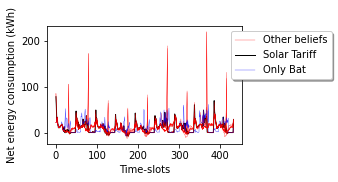

In [29]:
basic_plot(1234, True, False, 100)

2 neutral True 1
14 neutral True 5
26 optimistic True 1
38 optimistic True 5
56 pesimistic True 1
68 pesimistic True 5
86 solar True 1
98 solar True 5
110 unique True 1
122 unique True 5


,N,T,D,pt,market,freq,seed,only_update_price,flat,start,social_cost,increase_bottom_range,increase_top_range,local_matched
0,50,48,10,neutral,True,1,1234,False,False,100,-1.386105,-72.82,136.99,7.04
12,50,48,10,neutral,True,5,1234,False,False,100,-0.860821,13.48,122.98,-8.58
24,50,48,10,optimistic,True,1,1234,False,False,100,7.370046,-185.42,-47.91,91.65
36,50,48,10,optimistic,True,5,1234,False,False,100,7.373262,-138.35,-47.15,105.48
48,50,48,10,pesimistic,False,None,1234,False,False,100,0.000000,0.00,0.00,0.00
54,50,48,10,pesimistic,True,1,1234,False,False,100,-0.554227,-19.60,8.79,-1.63
66,50,48,10,pesimistic,True,5,1234,False,False,100,-0.498483,0.00,8.79,2.22
78,50,48,10,solar,False,None,1234,False,False,100,-6.687178,-1.70,-21.41,48.81
84,50,48,10,solar,True,1,1234,False,False,100,-0.602468,-44.03,15.28,45.50
96,50,48,10,solar,True,5,1234,False,False,100,-0.333394,-12.07,-16.08,9.46


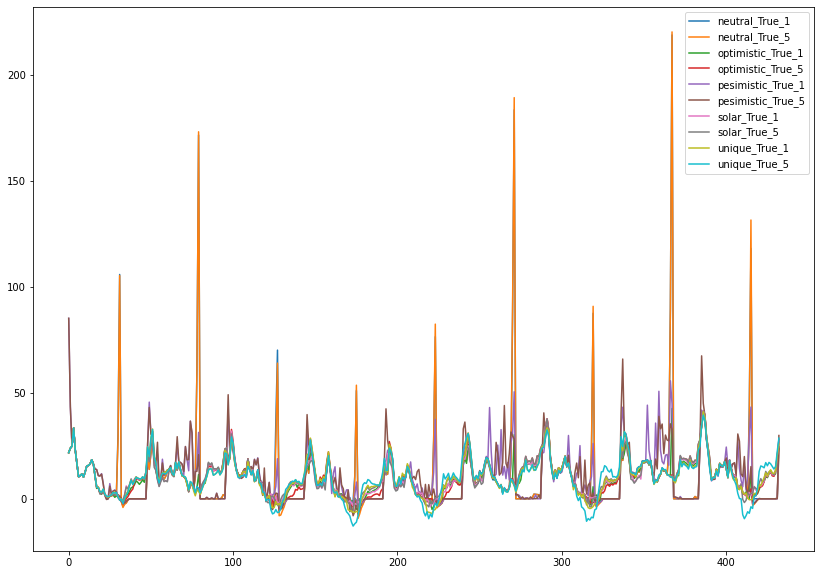

In [90]:
basic_plot(1234, False, False, 100)

In [63]:
def proc_data(num):
    key = KEYS[num]
    dt = data[key][1]
    pb = dt[0]['allprices'][:, 3][: L - 47]
    ps = dt[0]['allprices'][:, 0][: L - 47]
    
    net_load     = np.vstack([dt[n]['history_post_net'] for n in range(N)]).sum(axis=0)[: L - 47]
    net_pre      = np.vstack([dt[n]['history_pre_net'] for n in range(N)]).sum(axis=0)[: L - 47].round(1)
    #load         = np.vstack([dt[n]['allload'] for n in range(N)]).sum(axis=0)[: L - 47]
    #real_cost    = np.vstack([dt[n]['history_cost'] for n in range(N)]).sum(axis=0).sum().round(1)
    load = np.vstack([dt[n]['allload'][: L - 47] for n in range(N)])
    real_cost = np.array([dt[n]['history_cost'].sum() for n in range(N)])
    default_cost = (((load > 0).astype(float) * load * pb) + ((load < 0).astype(float) * load * ps))
#    real_cost_2 = (((net_load > 0).astype(float) * net_load * pb) + ((net_load < 0).astype(float) * net_load * ps)).sum().round(1)
    
    
    
    return net_load, net_pre, load, real_cost, default_cost

In [44]:
flat_default[2].shape

(50, 193)

In [49]:
bat = flat_default[3]
nobat = flat_default[4].sum(axis=1)

In [52]:
bat[4], nobat[4]

(3127.025168140514, 3125.1545552170483)

In [62]:
df.sort_values('seed')

,N,T,D,pt,market,freq,seed,only_update_price,flat,start
0,50,48,5,neutral,True,1,50,True,False,100
1,50,48,5,neutral,True,1,50,True,True,100
3,50,48,5,pesimistic,False,None,50,True,False,100
4,50,48,5,pesimistic,False,None,50,True,True,100
6,50,48,5,solar,True,1,50,True,False,100
7,50,48,5,solar,True,1,50,True,True,100
2,50,48,5,neutral,True,1,80,True,False,110
5,50,48,5,pesimistic,False,None,80,True,False,110


FLAT Cost only pure load  :  63602.01832695794
FLAT nly bat        :  55946.82892850336
FLAT market solar    :  52340.420978258415
FLAT market neutral  :  52898.34485444858
----------------------------------------
TOU Cost only pure load  :  48686.615481390465
TOU Cost only bat        :  36177.21990343974
TOU Cost market solar    :  39216.168682912066
TOU Cost market neutral  :  35744.523898326166


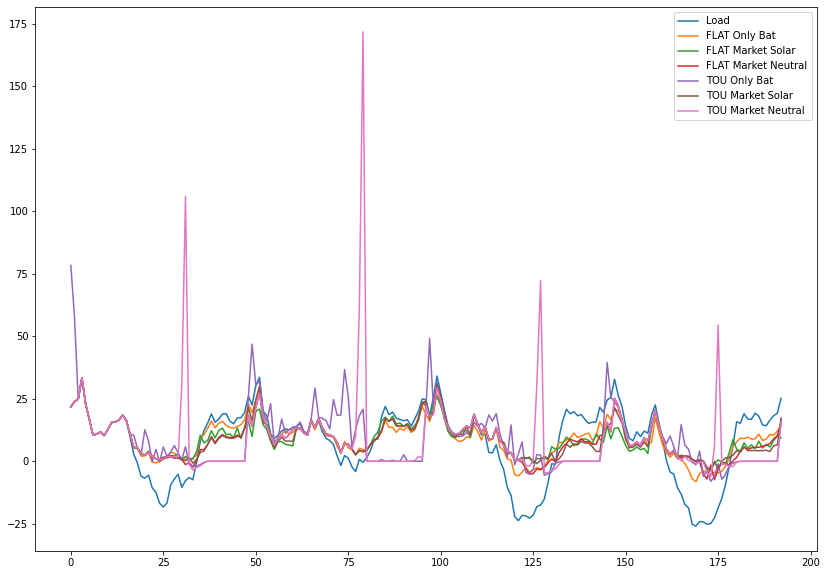

In [67]:
flat_solar = proc_data(7)
flat_default = proc_data(4)
flat_neutral = proc_data(1)

tou_solar = proc_data(6)
tou_default = proc_data(3)
tou_neutral = proc_data(0)

## Same base load
assert np.allclose(flat_solar[2] - flat_default[2], 0)
assert np.allclose(flat_solar[2] - flat_neutral[2], 0)
assert np.allclose(tou_solar[2] - flat_default[2], 0)
assert np.allclose(tou_solar[2] - tou_neutral[2], 0)
assert np.allclose(tou_solar[2] - tou_default[2], 0)


#### Begin Plot

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

ax.plot(flat_default[2].sum(axis=0), label='Load')
ax.plot(flat_default[0], label='FLAT Only Bat')
ax.plot(flat_solar[0], label='FLAT Market Solar')
ax.plot(flat_neutral[0], label='FLAT Market Neutral')

ax.plot(tou_default[0], label='TOU Only Bat')
ax.plot(tou_solar[0], label='TOU Market Solar')
ax.plot(tou_neutral[0], label='TOU Market Neutral')

ax.legend()

#### End Plot

#print("Cost pure load       : ", flat_default[4])
print("FLAT Cost only pure load  : ", flat_default[4].sum())
print("FLAT nly bat        : ", flat_default[3].sum())
print("FLAT market solar    : ", flat_solar[3].sum())
print("FLAT market neutral  : ", flat_neutral[3].sum())
print('--' * 20)
print("TOU Cost only pure load  : ", tou_default[4].sum())
print("TOU Cost only bat        : ", tou_default[3].sum())
print("TOU Cost market solar    : ", tou_solar[3].sum())
print("TOU Cost market neutral  : ", tou_neutral[3].sum())

2099.400314561955


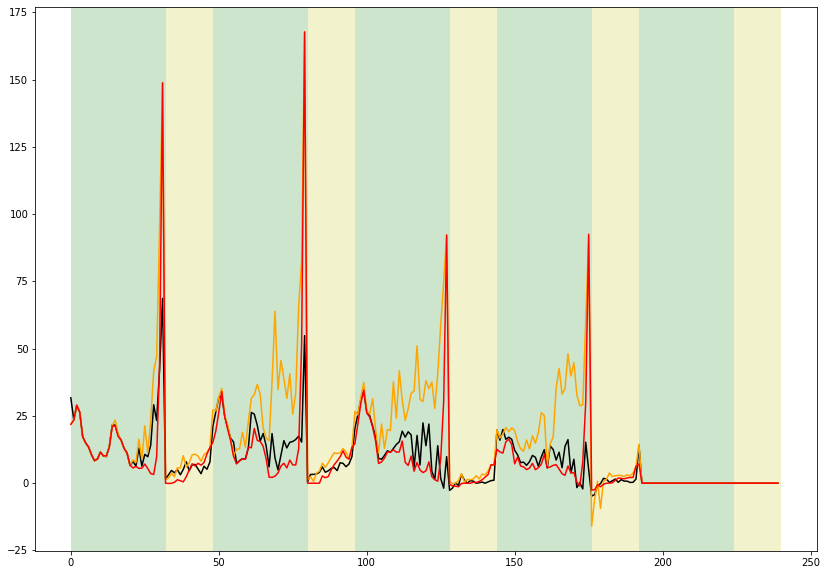

In [7]:
dd_1 = data['res/second/50-48-5-neutral-True-1-101-True-False-101?test2.pkl'][1]
v_post = np.vstack([dd_1[n]['history_post_net'] for n in range(N)]).sum(axis=0)
v_pre = np.vstack([dd_1[n]['history_pre_net'] for n in range(N)]).sum(axis=0)
l_market = np.vstack([dd_1[n]['allload'] for n in range(N)]).sum(axis=0)

market_cost = np.vstack([dd_1[n]['history_cost'] for n in range(N)]).sum(axis=0).sum()

prices_b = dd_1[0]['allprices'][:, 3]
prices_s = dd_1[0]['allprices'][:, 0]

dd_2 = data['res/second/50-48-5-pesimistic-False-None-101-True-False-101?test2.pkl'][1]
v_def = np.vstack([dd_2[n]['history_post_net'] for n in range(N)]).sum(axis=0)
l_def = np.vstack([dd_2[n]['allload'] for n in range(N)]).sum(axis=0)

bat_cost = np.vstack([dd_2[n]['history_cost'] for n in range(N)]).sum(axis=0).sum()

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)
ax.plot(v_def, c='k')
#ax.plot(l_def, c='b', linewidth=2)
#ax.plot(l_market, c='r')
ax.plot(v_pre, c='orange')
ax.plot(v_post, c='red')

for l in range(L):
    color = 'y' if prices_b[l] > 12 else 'g'
    ax.axvspan(l, l+1, facecolor=color, alpha=0.2)

print(l_def.sum())

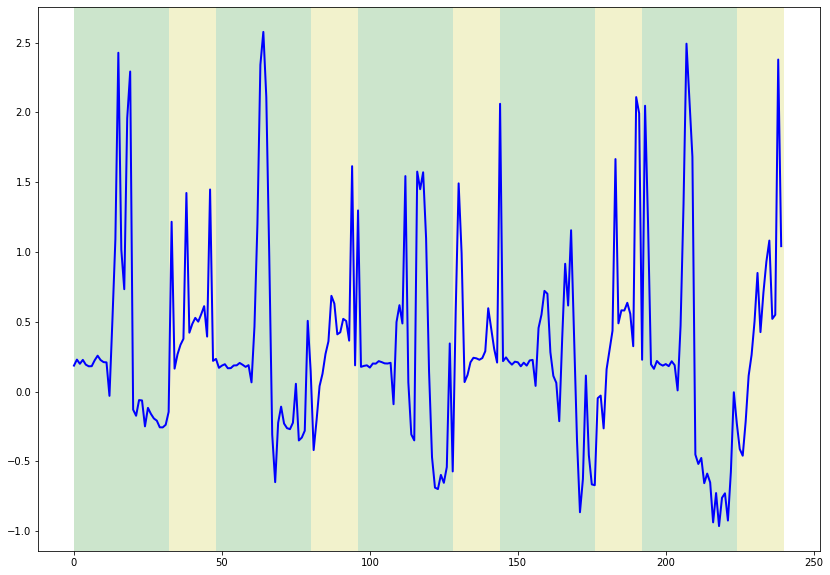

In [8]:
n = 0

dd_1 = data['res/second/50-48-5-optimistic-True-1-101-True-False-101?test2.pkl'][1]
v_post = dd_1[n]['history_post_net']
v_pre = dd_1[n]['history_pre_net']

#market_cost = np.vstack([dd_1[n]['history_cost'] for n in range(N)]).sum(axis=0).sum()

prices_b = dd_1[n]['allprices'][:, 3]
prices_s = dd_1[n]['allprices'][:, 0]

dd_2 = data['res/second/50-48-5-pesimistic-False-None-101-True-False-101?test2.pkl'][1]
v_def = dd_2[n]['history_post_net'] 
l_def = dd_2[n]['allload']

#bat_cost = np.vstack([dd_2[n]['history_cost'] for n in range(N)]).sum(axis=0).sum()

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)
#plt.plot(v_market, c='r')
#ax.plot(v_def, c='k')
ax.plot(l_def, c='b', linewidth=2)
#ax.plot(l_market, c='r')
#ax.plot(v_pre, c='orange', linewidth=3)
#ax.plot(v_post, c='red')
for l in range(L):
    color = 'y' if prices_b[l] > 12 else 'g'
    ax.axvspan(l, l+1, facecolor=color, alpha=0.2)

#print(l_def.sum())

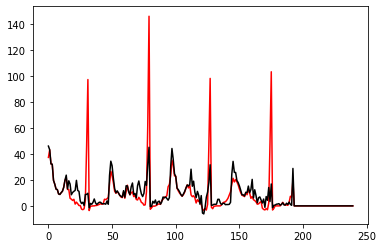

In [9]:
dd_1 = data['res/second/50-48-5-neutral-True-1-80-True-False-80?test2.pkl'][1]
v_market = np.vstack([dd_1[n]['history_post_net'] for n in range(N)]).sum(axis=0)

dd_2 = data['res/second/50-48-5-pesimistic-False-None-80-True-False-80?test2.pkl'][1]
v_def = np.vstack([dd_2[n]['history_post_net'] for n in range(N)]).sum(axis=0)

plt.plot(v_market, c='r')
plt.plot(v_def, c='k')

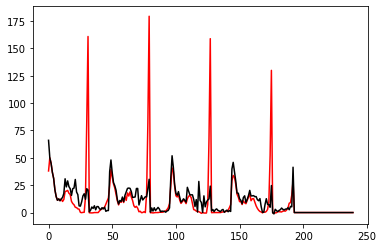

In [17]:
dd_1 = data['res/second/50-48-5-neutral-True-1-50-True-False-50?test2.pkl'][1]
v_market = np.vstack([dd_1[n]['history_post_net'] for n in range(N)]).sum(axis=0)

dd_2 = data['res/second/50-48-5-pesimistic-False-None-50-True-False-50?test2.pkl'][1]
v_def = np.vstack([dd_2[n]['history_post_net'] for n in range(N)]).sum(axis=0)

plt.plot(v_market, c='r')
plt.plot(v_def, c='k')

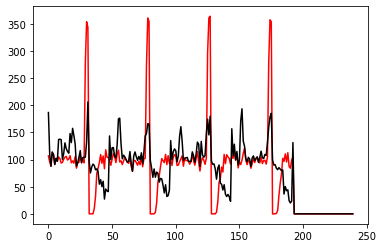

In [11]:
dd_1 = data['res/second/50-48-5-neutral-True-1-200-True-False--1?test2.pkl'][1]
v_market = np.vstack([dd_1[n]['history_post_net'] for n in range(N)]).sum(axis=0)

dd_2 = data['res/second/50-48-5-pesimistic-False-None-200-True-False--1?test2.pkl'][1]
v_def = np.vstack([dd_2[n]['history_post_net'] for n in range(N)]).sum(axis=0)

plt.plot(v_market, c='r')
plt.plot(v_def, c='k')

/home/guso/github/lemsim_code/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


Text(0.5, 1.0, 'Players learn only market prices but not market quantities. Flat Rate')

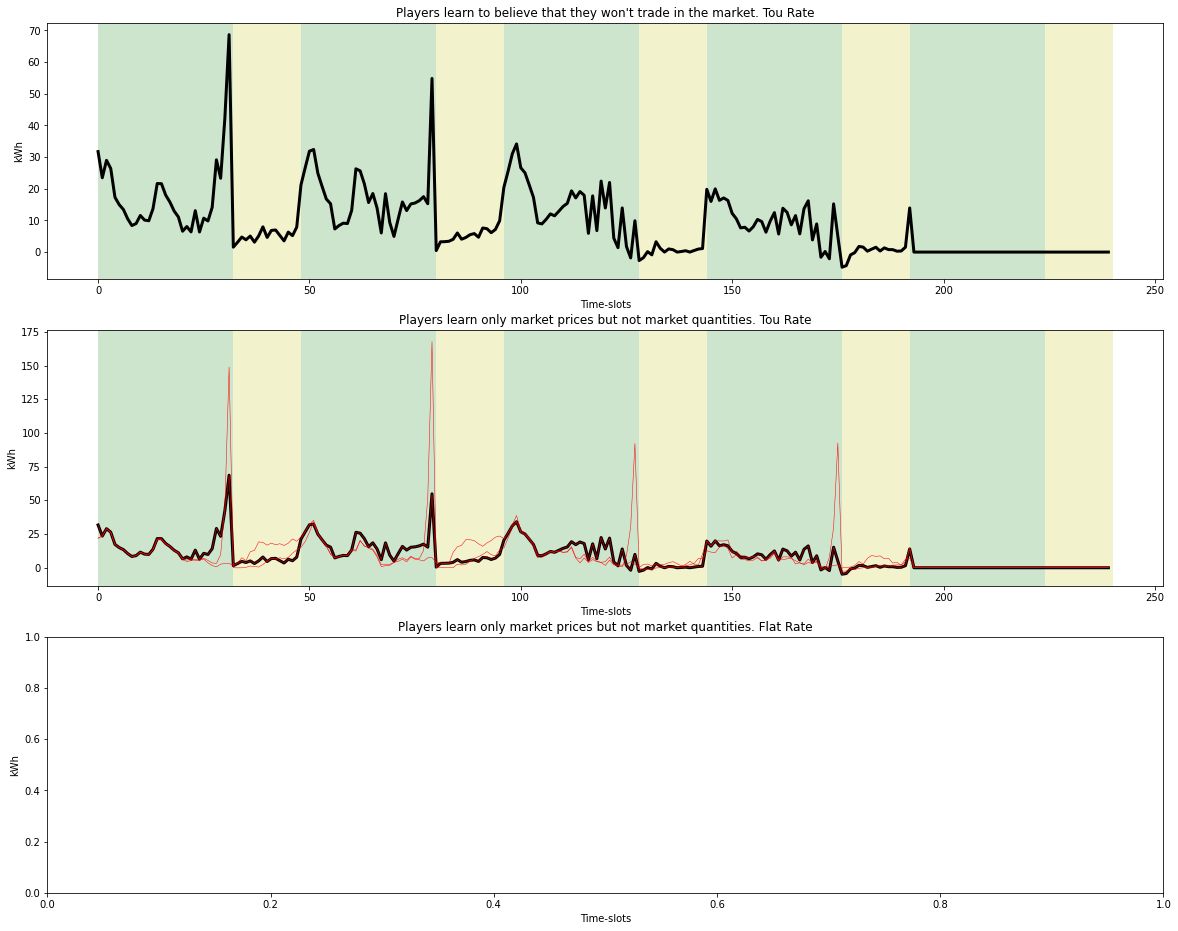

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(20, 16))

SEED = 101

df_ = df[(df.seed == SEED)]

no_market_tou_idx = df_[(df_.freq == 'None') & (df.flat==False)].index[0] 
data_ = data[KEYS[no_market_tou_idx]][1]
prices_tou = ['y' if p > 12 else 'g' for p in data_[0]['allprices'][:,3]]
val_no_market_tou = np.vstack([data_[n]['history_post_net'] for n in range(N)]).sum(axis=0)[:L]

#no_market_flat_idx = df_[(df_.freq == 'None') & (df.flat==True)].index[0] 
#data_ = data[KEYS[no_market_flat_idx]][1]
#prices_flat = ['y' if p > 12 else 'g' for p in data_[0]['allprices'][:,3]]
#val_no_market_flat = np.vstack([data_[n]['history_post_net'] for n in range(N)]).sum(axis=0)[:433]

upq_tou_idx = df_[(df_.only_update_price == False) & (df_.flat == False)].index.values
up_tou_idx = df_[(df_.only_update_price == True) & (df_.flat == False)].index.values
#up_flat_idx = df_[(df_.only_update_price == True) & (df_.flat == True)].index.values


for l in range(L):
    ax[0].axvspan(l, l+1, facecolor=prices_tou[l], alpha=0.2)
    ax[1].axvspan(l, l+1, facecolor=prices_tou[l], alpha=0.2)
    #ax[2].axvspan(l, l+1, facecolor=prices_flat[l], alpha=0.2)

ax[0].plot(val_no_market_tou, c='k', linewidth=3)
ax[1].plot(val_no_market_tou, c='k', linewidth=3)
#ax[2].plot(val_no_market_flat, c='k', linewidth=3)

for i in range(3):
    ax[i].set_xlabel('Time-slots')
    ax[i].set_ylabel('kWh')
    
    
## Update prices and quantities, TOU
for idx in upq_tou_idx:
    k = KEYS[idx]
    data_ = data[k][1]
    val = np.vstack([data_[n]['history_post_net'] for n in range(N)]).sum(axis=0)[:L]
    ax[0].plot(val, c='r', linewidth = 0.5)
    
## Update only prices, TOU
for idx in up_tou_idx:
    k = KEYS[idx]
    data_ = data[k][1]
    val = np.vstack([data_[n]['history_post_net'] for n in range(N)]).sum(axis=0)[:L]
    ax[1].plot(val, c='r', linewidth = 0.5)
    
## Update prices and quantities, flat rate
#for idx in upq_flat_idx:
#    k = KEYS[idx]
#    data_ = data[k][1]
#    val = np.vstack([data_[n]['history_post_net'] for n in range(N)]).sum(axis=0)[:433]
#    ax[2].plot(val, c='r', linewidth = 0.5)

# Upadte only prices, flat rate
#for idx in up_flat_idx:
#    k = KEYS[idx]
#    data_ = data[k][1]
#    val = np.vstack([data_[n]['history_post_net'] for n in range(N)]).sum(axis=0)[:433]
#    ax[2].plot(val, c='r', linewidth = 0.5)

ax[0].set_title("Players learn to believe that they won't trade in the market. Tou Rate")
ax[1].set_title("Players learn only market prices but not market quantities. Tou Rate")
ax[2].set_title("Players learn only market prices but not market quantities. Flat Rate")

#fig.savefig('Figure_1.png', dpi=200)

In [19]:
PT = 'solar'

In [20]:
def plot_pre_post(PT):
    df_ = df[(df.seed == 69) & (df.freq == '5') & (df.pt == PT) & (df.flat == False)]
    df_

    UP = df_[(df_.only_update_price == True)].index[0]
    UPQ = df_[(df_.only_update_price == False)].index[0]

    fig, ax = plt.subplots(2, 1, figsize=(20, 16))



    # UPQ
    data_ = data[KEYS[UPQ]][1]
    prices_TOU = ['y' if p > 12 else 'g' for p in data_[0]['allprices'][:,3]]
    val_UPQ_pre = np.vstack([data_[n]['history_pre_net'] for n in range(N)]).sum(axis=0)[:433]
    val_UPQ_post = np.vstack([data_[n]['history_post_net'] for n in range(N)]).sum(axis=0)[:433]

    for l in range(433):
        ax[0].axvspan(l, l+1, facecolor=prices_tou[l], alpha=0.2)
        ax[1].axvspan(l, l+1, facecolor=prices_tou[l], alpha=0.2)

    ax[1].plot(val_UPQ_pre, c='b', label='Quantity bidded in the market')
    ax[1].plot(val_UPQ_post, c='k',label='Real quantity consumed at the end of the period')
    ax[1].legend()
    ax[1].set_title('[{0}] Players learn that they do not trade that much in the market. Dumping effect at the end'.format(PT))

    # UP
    data_ = data[KEYS[UP]][1]
    prices_TOU = ['y' if p > 12 else 'g' for p in data_[0]['allprices'][:,3]]
    val_UP_pre = np.vstack([data_[n]['history_pre_net'] for n in range(N)]).sum(axis=0)[:433]
    val_UP_post = np.vstack([data_[n]['history_post_net'] for n in range(N)]).sum(axis=0)[:433]


    ax[0].plot(val_UP_pre, c='b', label='Quantity bidded in the market')
    ax[0].plot(val_UP_post, c='k',label='Real quantity consumed at the end of the period')
    ax[0].legend()
    ax[0].set_title('[{0}] Players remain optimistic about the amount of energy they will trade in the market'.format(PT))

    #fig.savefig("Figure_2_{0}.png".format(PT), dpi=200)


In [23]:
#plot_pre_post("solar")
#plot_pre_post("optimistic")
plot_pre_post("pesimistic")

IndexError: index 0 is out of bounds for axis 0 with size 0